In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib
from matplotlib import pyplot as plt

### Load Data

In [2]:
# Stock price of Apple from 2010/1/4 to 2021-02-26
AAPL = pd.read_csv('AAPL.csv')
AAPL['Date'] = AAPL['Date'].astype('datetime64[ns]')
AAPL

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.594968,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.490066,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.478067,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.521136,447610800
...,...,...,...,...,...,...,...
2836,2021-04-12,132.520004,132.850006,130.630005,131.240005,131.240005,91420000
2837,2021-04-13,132.440002,134.660004,131.929993,134.429993,134.429993,91266500
2838,2021-04-14,134.940002,135.000000,131.660004,132.029999,132.029999,87222800
2839,2021-04-15,133.820007,135.000000,133.639999,134.500000,134.500000,89347100


# Visualize

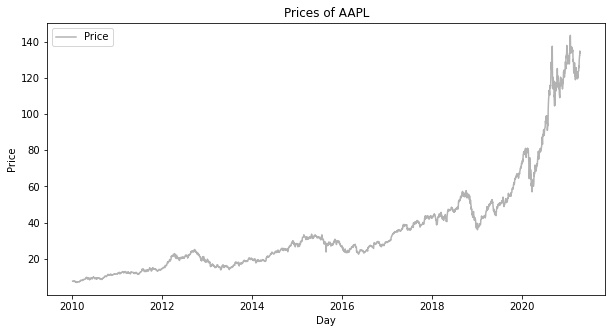

In [3]:
# Visualize prices from 2010 t0 2021
start = 0
end = -1

plt.figure(figsize=(10,5))
plt.plot(AAPL['Date'][start:end], AAPL[['Open']][start:end], label='Price', c='grey', alpha=0.6)

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Prices of AAPL')
plt.legend()
plt.show()

In [4]:
SMA20s = AAPL['Open'].rolling(window=20, center=False).mean()

In [5]:
SMA50s = AAPL['Open'].rolling(window=50, center=False).mean()

## RSI Calculation

In [6]:
    prices = []
    c = 0
    # Add the closing prices to the prices list and make sure we start at greater than 2 dollars to reduce outlier calculations.
    while c < len(AAPL):
        if AAPL.iloc[c,4] > float(2.00):  # Check that the closing price for this day is greater than $2.00
            prices.append(AAPL.iloc[c,4])
        c += 1
    # prices_df = pd.DataFrame(prices)  # Make a dataframe from the prices list
    i = 0
    upPrices=[]
    downPrices=[]
    #  Loop to hold up and down price movements
    while i < len(prices):
        if i == 0:
            upPrices.append(0)
            downPrices.append(0)
        else:
            if (prices[i]-prices[i-1])>0:
                upPrices.append(prices[i]-prices[i-1])
                downPrices.append(0)
            else:
                downPrices.append(prices[i]-prices[i-1])
                upPrices.append(0)
        i += 1
    x = 0
    avg_gain = []
    avg_loss = []
    #  Loop to calculate the average gain and loss
    while x < len(upPrices):
        if x <15:
            avg_gain.append(0)
            avg_loss.append(0)
        else:
            sumGain = 0
            sumLoss = 0
            y = x-14
            while y<=x:
                sumGain += upPrices[y]
                sumLoss += downPrices[y]
                y += 1
            avg_gain.append(sumGain/14)
            avg_loss.append(abs(sumLoss/14))
        x += 1
    p = 0
    RS = []
    RSI = []
    #  Loop to calculate RSI and RS
    while p < len(prices):
        if p <15:
            RS.append(0)
            RSI.append(0)
        else:
            RSvalue = (avg_gain[p]/avg_loss[p])
            RS.append(RSvalue)
            RSI.append(100 - (100/(1+RSvalue)))
        p+=1
    #  Creates the csv for each stock's RSI and price movements
    df_dict = {
        'Prices' : prices,
        'upPrices' : upPrices,
        'downPrices' : downPrices,
        'AvgGain' : avg_gain,
        'AvgLoss' : avg_loss,
        'RS' : RS,
        'RSI' : RSI
    }
    df = pd.DataFrame(df_dict, columns = ['Prices', 'upPrices', 'downPrices', 'AvgGain','AvgLoss', 'RS', "RSI"])

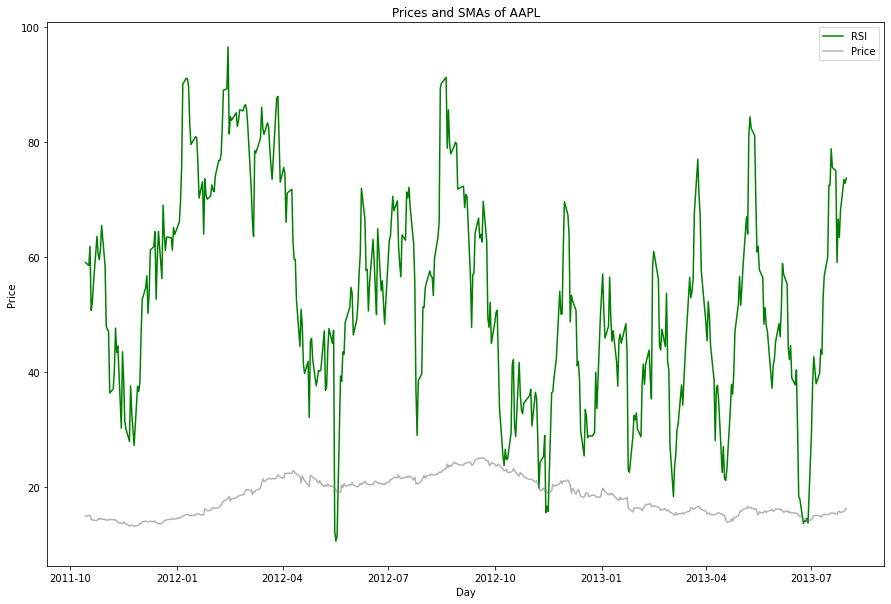

In [7]:
# Visualize RSI and prices
plt.figure(figsize=(15,10))
plt.plot(AAPL[['Date']][450:900], df['RSI'][450:900], label='RSI', c='green')
#plt.plot(AAPL[['Date']][450:900], SMA50s[450:900], label='SMA50', c='red')
plt.plot(AAPL[['Date']][450:900], AAPL[['Open']][450:900], label='Price', c='grey', alpha=0.6)

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Prices and SMAs of AAPL')
plt.legend()
plt.show()

From the plot, we can see when SMA20 meets SMA 50, it is a good indicator to either buy or sell stocks:
- When SMA20 becomes greater than SMA50: Buy signal
- When SMA20 becomes smaller than SMA20: Sell signal

In [8]:
df.head()

,Prices,upPrices,downPrices,AvgGain,AvgLoss,RS,RSI
0,7.643214,0.000000,0.000000,0.0,0.0,0.0,0.0
1,7.656429,0.013215,0.000000,0.0,0.0,0.0,0.0
2,7.534643,0.000000,-0.121786,0.0,0.0,0.0,0.0
3,7.520714,0.000000,-0.013929,0.0,0.0,0.0,0.0
4,7.570714,0.050000,0.000000,0.0,0.0,0.0,0.0


### Building the Agent

In [9]:
# Determine when to excecute the strategies
class RSI_Agent:
    
    def __init__(self, wallet):
        self.data = None
        self.wallet = wallet # Amount of cash in hand
        self.portfolio = 0 # Company stock count
        self.current_market = None
        self.history = [[[],[]],[[],[]]] # 1st arr: Buy history; 2nd arr: sell history. [date, price]
        self.sma_diff = [] #
    
    # Check if the agent can buy the stock
    # Returns: Boolean. True if can buy, False if not
    def can_buy(self, unit):
        if unit == -1:
            if self.wallet >= self.current_market['Open']:
                return True
        else:
            if self.wallet >= unit*self.current_market['Open']:
                return True
        return False
    
    # Check if the agent can sell the stock
    # Returns: Boolean. True if can sell, False if not
    def can_sell(self, unit):
        if unit == -1:
            if self.portfolio > 0:
                return True
        else:
            if self.portfolio >= unit:
                return True
        return False
    
    # Buys x unit of stock. -1 to spend all
    def buy(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = math.floor(self.wallet/current_price)
        self.wallet -= unit*current_price
        self.portfolio += unit
        self.history[0][0].append(self.current_market['Date'])
        self.history[0][1].append(current_price)
    
    # Sells x unit of stock. -1 to sell all
    def sell(self, unit):
        current_price = self.current_market['Open'] # price 1 stock
        # Update fields
        if unit == -1:
            unit = self.portfolio
        self.wallet += unit*current_price
        self.portfolio -= unit
        self.history[1][0].append(self.current_market['Date'])
        self.history[1][1].append(current_price)
    
    # Computes the total balance: wallet + holdings
    def total_balance(self):
        current_price = self.current_market['Open'] # price 1 stock
        return self.wallet + current_price*self.portfolio
    
    # Computes the "smooth moving average of past 50 days"
    def sma50(self):
        date = self.current_market.Date
        index = self.data.loc[self.data['Date'] == date].index[0]
        return self.data['Open'].rolling(window=50, center=False).mean()[index]
    
    # Computes the "smooth moving average of past 20 days"
    def sma20(self):
        date = self.current_market.Date
        index = self.data.loc[self.data['Date'] == date].index[0]
        return self.data['Open'].rolling(window=20, center=False).mean()[index]
    
    def RSI(self, df):
        date = self.current_market.Date
        index = self.data.loc[self.data['Date'] == date].index[0]
        return df['RSI'][index]
    
    # Defines the buying/selling strategy
    # Buy when sma20 goes above sma50
    # Sell when sma20 goes below sma50
    def strategy(self,df):
        # first iteration
        #sma20 = SMA_Agent.sma20(self)
        #sma50 = SMA_Agent.sma50(self)
        #new_sma_diff = sma20-sma50
        rsi = RSI_Agent.RSI(self,df)
        
        # first iteration
        if rsi != 0:
            if rsi > 70 and RSI_Agent.can_buy(self,-1):
                # Buy signal
                RSI_Agent.buy(self,-1)
            elif rsi < 30 and RSI_Agent.can_sell(self,-1):
                # sell signal
                RSI_Agent.sell(self,-1)
        #self.sma_diff.append(new_sma_diff)
    
    # Given a dataframe computes the buy and sell signals
    def deploy(self, data, df):
        self.data = data.reset_index()
        for (idx, row) in self.data.iterrows():
            self.current_market = data.iloc[idx]
            if idx > 49: # first day where SMA50 is computed
                RSI_Agent.strategy(self,df)
        return self.history

### Run and Evaluate Bot

In [10]:
# Inputs
invest = 1000
start_from = 2667
end_from = -1
data = AAPL[start_from:end_from]

agent = RSI_Agent(invest)
buy_info, sell_info = agent.deploy(data,df)

In [11]:
# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data.iloc[-1].Open-data.iloc[0].Open)/data.iloc[0].Open, '%')

Invested: 1000
End of day total balance: 1092.2399920000003
Percentage gain: 9.223999200000026 %

Baseline: 18.210330494053608 %


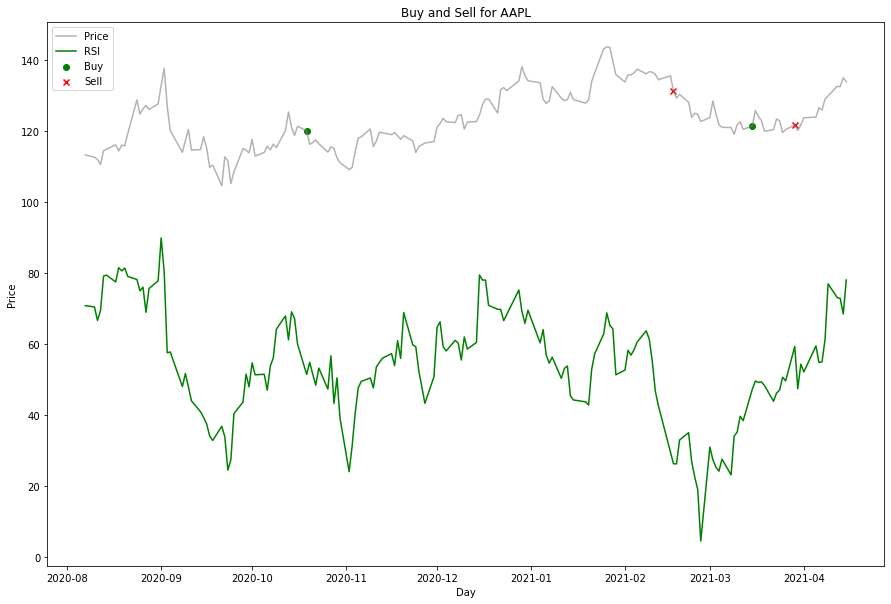

In [12]:
# Visualize RSI and prices
plt.figure(figsize=(15,10))
plt.plot(data[['Date']], data[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
#plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)
plt.plot(data[['Date']], df['RSI'][start_from:end_from], label='RSI', c='green')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

## Repeat with S&P 500

In [13]:
# Stock price of Apple from 2010/1/4 to 2021-02-26
SPY = pd.read_csv('SPY.csv')
SPY['Date'] = SPY['Date'].astype('datetime64[ns]')
SPY

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,112.370003,113.389999,111.510002,113.330002,90.790062,118944600
1,2010-01-05,113.260002,113.680000,112.849998,113.629997,91.030411,111579900
2,2010-01-06,113.519997,113.989998,113.430000,113.709999,91.094490,116074400
3,2010-01-07,113.500000,114.330002,113.180000,114.190002,91.479050,131091100
4,2010-01-08,113.889999,114.620003,113.660004,114.570000,91.783432,126402800
...,...,...,...,...,...,...,...
2836,2021-04-12,410.850006,411.929993,410.200012,411.640015,411.640015,56704900
2837,2021-04-13,411.529999,413.529999,411.119995,412.859985,412.859985,56551000
2838,2021-04-14,412.829987,413.959991,410.869995,411.450012,411.450012,61659900
2839,2021-04-15,413.739990,416.160004,413.690002,415.869995,415.869995,60229800


In [14]:
        prices = []
        c = 0
        # Add the closing prices to the prices list and make sure we start at greater than 2 dollars to reduce outlier calculations.
        while c < len(SPY):
            if SPY.iloc[c,4] > float(2.00):  # Check that the closing price for this day is greater than $2.00
                prices.append(SPY.iloc[c,4])
            c += 1
        # prices_df = pd.DataFrame(prices)  # Make a dataframe from the prices list
        i = 0
        upPrices=[]
        downPrices=[]
        #  Loop to hold up and down price movements
        while i < len(prices):
            if i == 0:
                upPrices.append(0)
                downPrices.append(0)
            else:
                if (prices[i]-prices[i-1])>0:
                    upPrices.append(prices[i]-prices[i-1])
                    downPrices.append(0)
                else:
                    downPrices.append(prices[i]-prices[i-1])
                    upPrices.append(0)
            i += 1
        x = 0
        avg_gain = []
        avg_loss = []
        #  Loop to calculate the average gain and loss
        while x < len(upPrices):
            if x <15:
                avg_gain.append(0)
                avg_loss.append(0)
            else:
                sumGain = 0
                sumLoss = 0
                y = x-14
                while y<=x:
                    sumGain += upPrices[y]
                    sumLoss += downPrices[y]
                    y += 1
                avg_gain.append(sumGain/14)
                avg_loss.append(abs(sumLoss/14))
            x += 1
        p = 0
        RS = []
        RSI = []
        #  Loop to calculate RSI and RS
        while p < len(prices):
            if p <15:
                RS.append(0)
                RSI.append(0)
            else:
                RSvalue = (avg_gain[p]/avg_loss[p])
                RS.append(RSvalue)
                RSI.append(100 - (100/(1+RSvalue)))
            p+=1
        #  Creates the csv for each stock's RSI and price movements
        df_dict = {
            'Prices' : prices,
            'upPrices' : upPrices,
            'downPrices' : downPrices,
            'AvgGain' : avg_gain,
            'AvgLoss' : avg_loss,
            'RS' : RS,
            'RSI' : RSI
        }
        df_spy = pd.DataFrame(df_dict, columns = ['Prices', 'upPrices', 'downPrices', 'AvgGain','AvgLoss', 'RS', "RSI"])

In [15]:
# Inputs
invest = 1000
start_from = 2667
end_from = -1
data = SPY[start_from:end_from]

agent = RSI_Agent(invest)
buy_info, sell_info = agent.deploy(data,df_spy)

In [16]:
# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data.iloc[-1].Open-data.iloc[0].Open)/data.iloc[0].Open, '%')

Invested: 1000
End of day total balance: 1059.21997
Percentage gain: 5.92199700000001 %

Baseline: 24.141860070036767 %


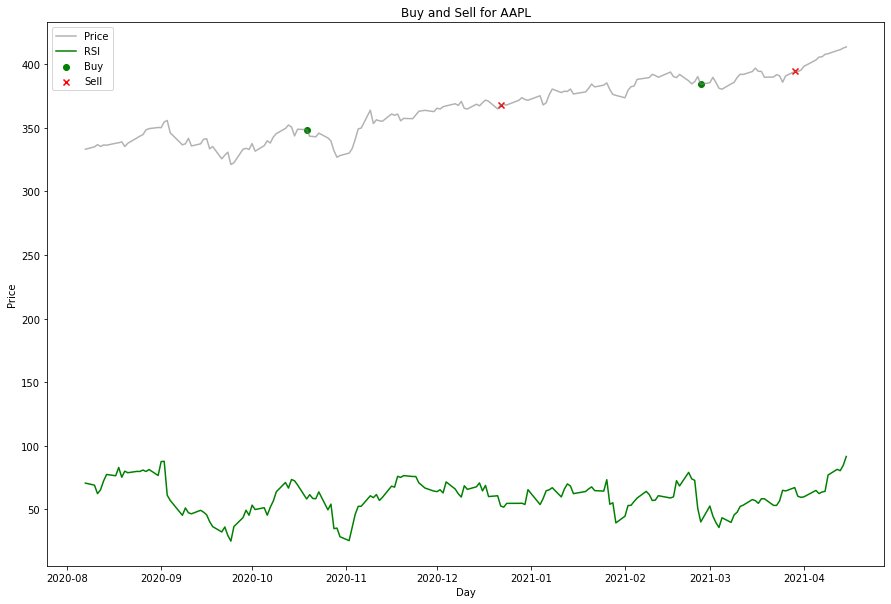

In [18]:
# Visualize RSI and prices
plt.figure(figsize=(15,10))
plt.plot(data[['Date']], data[['Open']], label='Price', c='grey', alpha=0.6)
plt.scatter(buy_info[0], buy_info[1], marker='o', label='Buy', c='green')
plt.scatter(sell_info[0], sell_info[1], marker='x', label='Sell', c='red')

#plt.plot(data[['Date']], SMA20s[start_from:end_from], label='SMA20', c='green', alpha=0.6)
#plt.plot(data[['Date']], SMA50s[start_from:end_from], label='SMA50', c='red', alpha=0.6)
plt.plot(data[['Date']], df_spy['RSI'][start_from:end_from], label='RSI', c='green')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

## Repeat with Amazon

In [19]:
# Stock price of Apple from 2010/1/4 to 2021-02-26
AMZN = pd.read_csv('AMZN.csv')
AMZN['Date'] = AMZN['Date'].astype('datetime64[ns]')
AMZN

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500
...,...,...,...,...,...,...,...
2836,2021-04-12,3355.209961,3395.040039,3351.149902,3379.389893,3379.389893,3281800
2837,2021-04-13,3400.850098,3432.000000,3395.629883,3400.000000,3400.000000,3315800
2838,2021-04-14,3404.040039,3404.129883,3326.000000,3333.000000,3333.000000,3145200
2839,2021-04-15,3371.000000,3397.000000,3352.000000,3379.090088,3379.090088,3233600


In [21]:
        prices = []
        c = 0
        # Add the closing prices to the prices list and make sure we start at greater than 2 dollars to reduce outlier calculations.
        while c < len(SPY):
            if SPY.iloc[c,4] > float(2.00):  # Check that the closing price for this day is greater than $2.00
                prices.append(SPY.iloc[c,4])
            c += 1
        # prices_df = pd.DataFrame(prices)  # Make a dataframe from the prices list
        i = 0
        upPrices=[]
        downPrices=[]
        #  Loop to hold up and down price movements
        while i < len(prices):
            if i == 0:
                upPrices.append(0)
                downPrices.append(0)
            else:
                if (prices[i]-prices[i-1])>0:
                    upPrices.append(prices[i]-prices[i-1])
                    downPrices.append(0)
                else:
                    downPrices.append(prices[i]-prices[i-1])
                    upPrices.append(0)
            i += 1
        x = 0
        avg_gain = []
        avg_loss = []
        #  Loop to calculate the average gain and loss
        while x < len(upPrices):
            if x <15:
                avg_gain.append(0)
                avg_loss.append(0)
            else:
                sumGain = 0
                sumLoss = 0
                y = x-14
                while y<=x:
                    sumGain += upPrices[y]
                    sumLoss += downPrices[y]
                    y += 1
                avg_gain.append(sumGain/14)
                avg_loss.append(abs(sumLoss/14))
            x += 1
        p = 0
        RS = []
        RSI = []
        #  Loop to calculate RSI and RS
        while p < len(prices):
            if p <15:
                RS.append(0)
                RSI.append(0)
            else:
                RSvalue = (avg_gain[p]/avg_loss[p])
                RS.append(RSvalue)
                RSI.append(100 - (100/(1+RSvalue)))
            p+=1
        #  Creates the csv for each stock's RSI and price movements
        df_dict = {
            'Prices' : prices,
            'upPrices' : upPrices,
            'downPrices' : downPrices,
            'AvgGain' : avg_gain,
            'AvgLoss' : avg_loss,
            'RS' : RS,
            'RSI' : RSI
        }
        df_amzn = pd.DataFrame(df_dict, columns = ['Prices', 'upPrices', 'downPrices', 'AvgGain','AvgLoss', 'RS', "RSI"])

In [24]:
# Inputs
invest = 10000
start_from = 2667
end_from = -1
data = AMZN[start_from:end_from]

agent = RSI_Agent(invest)
buy_info, sell_info = agent.deploy(data,df_amzn)

In [25]:
# Check performance
print('Invested:', invest)
print('End of day total balance:', agent.total_balance())
print('Percentage gain:', 100*(agent.total_balance()-invest)/invest, '%')

print()
print('Baseline:', 100*(data.iloc[-1].Open-data.iloc[0].Open)/data.iloc[0].Open, '%')

Invested: 10000
End of day total balance: 9590.409913
Percentage gain: -4.095900870000005 %

Baseline: 4.559228710335177 %
